# Sweet Lift Taxi

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### 1. Importar librerías necesarias

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Cargar datos

In [3]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
#analizar datos nulos
df.info()
print('')
#analizar valores duplicados
print('Duplicados:', df.duplicated().sum())
print('')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB

Duplicados: 0



,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


El dataframe consta de dos columnas datetime que corresponde a la fecha y hora y el número de ordenes de taxis. Se puede observar que no existen valores nulos ni duplicados en el dataframe.  

### 3. EDA

In [4]:
#Indexar por fecha y hora
df = df.set_index('datetime')

#Ordenar el índice y comprobar el orden
df = df.sort_index()
print('Indice ordenado:', df.index.is_monotonic_increasing)
print('')

#Observar el nuevo dataframe
df.info()

Indice ordenado: True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
#Remuestreo por hora
df_res = df.resample('1H').sum()

#analizar valores nulos
df_res.info()
print('')

#analizar fechas duplicadas
print('duplicados en el índice de fechas:', df_res.index.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB

duplicados en el índice de fechas: 0


Se realizó el remuestreo de datos por hora y se comprobó que no existen valores ausentes ni duplicados en el índice.

In [6]:
#Rango temporal
print('Rango temporal:', df_res.index.min(),'-', df_res.index.max())

Rango temporal: 2018-03-01 00:00:00 - 2018-08-31 23:00:00


<AxesSubplot:xlabel='num_orders'>

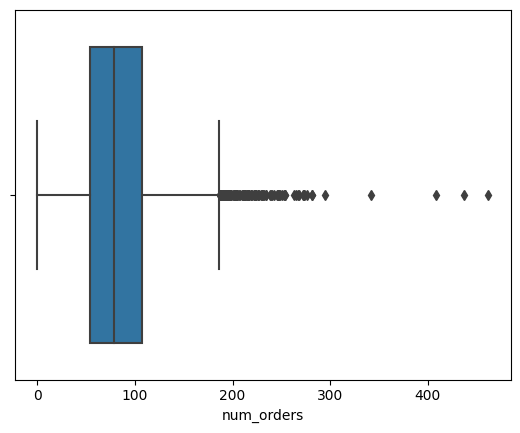

In [7]:
#analizar valores máximos, mínimos y atípicos
df_res.describe()
print('')
sns.boxplot(df_res['num_orders'])

In [8]:
Q1 = df_res['num_orders'].quantile(0.25)
Q3 = df_res['num_orders'].quantile(0.75)
IQR = Q3 - Q1

limite_min = Q1 - 1.5 * IQR
limite_max = Q3 + 1.5 * IQR

print('Q1', Q1)
print('Q3', Q3)
print('IQR', IQR)
print('limite inferior', limite_min)
print('limite superior', limite_max)

Q1 54.0
Q3 107.0
IQR 53.0
limite inferior -25.5
limite superior 186.5


Es evidente que existen valores atípicos en el conjunto de datos que deben ser tratados antes de generar el modelo predictivo. En este sentido, se aplicará StandardScaler para estandarizar los datos.

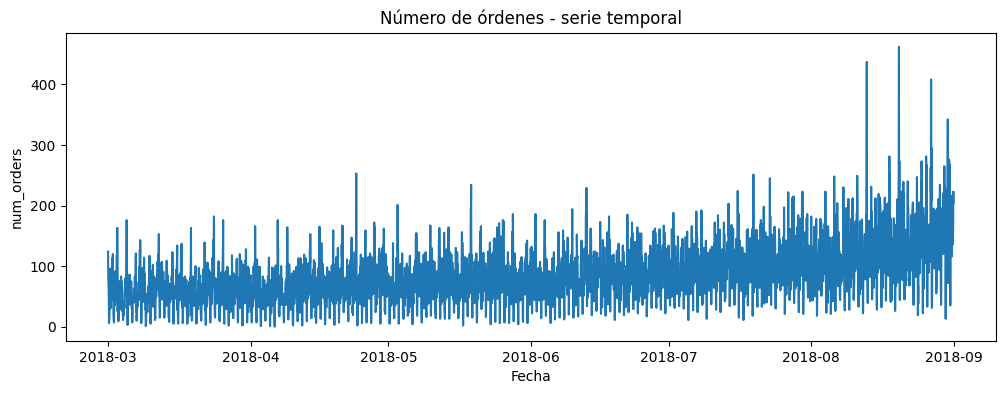

In [9]:
#Visualización serie temporal
plt.figure(figsize=(12,4))
plt.plot(df_res)
plt.title("Número de órdenes - serie temporal")
plt.xlabel("Fecha")
plt.ylabel('num_orders')
plt.show()

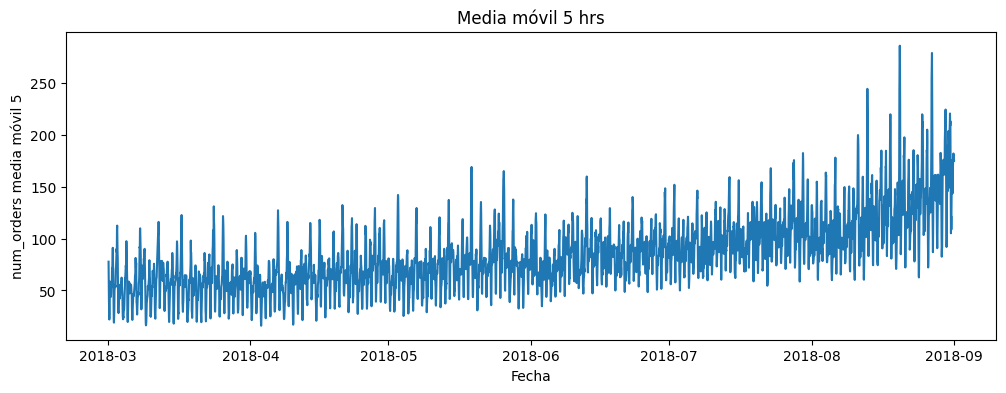

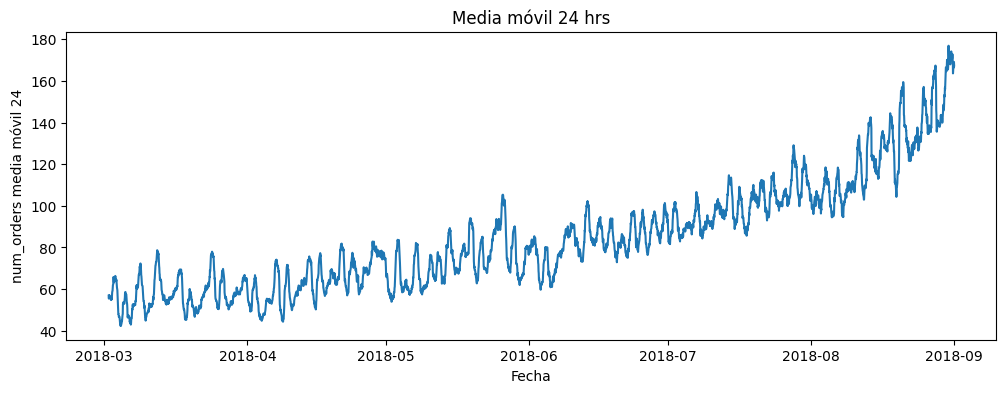

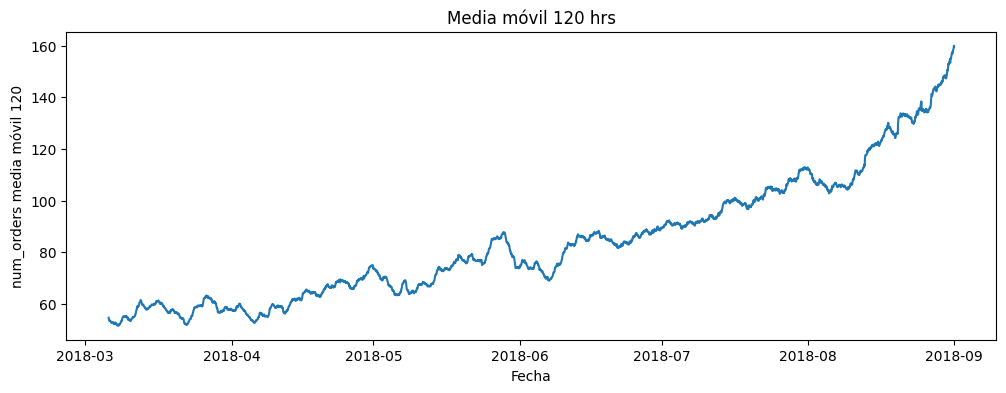

In [10]:
#Medias móviles
for i in [5, 24, 120]:
    plt.figure(figsize=(12,4))
    plt.plot(df_res.rolling(i).mean())
    plt.title(f"Media móvil {i} hrs")
    plt.xlabel('Fecha')
    plt.ylabel(f"num_orders media móvil {i}")
    plt.show()


Se observa una clara tendencia de crecimiento en el número de órdenes de marzo a septiembre 2018. Por otra parte, suavizando la serie con las medias móviles se observan fluctuaciones que pueden deberse a pedidos en horas pico o ruido.

## Análisis

Text(0.5, 1.0, 'Residuales')

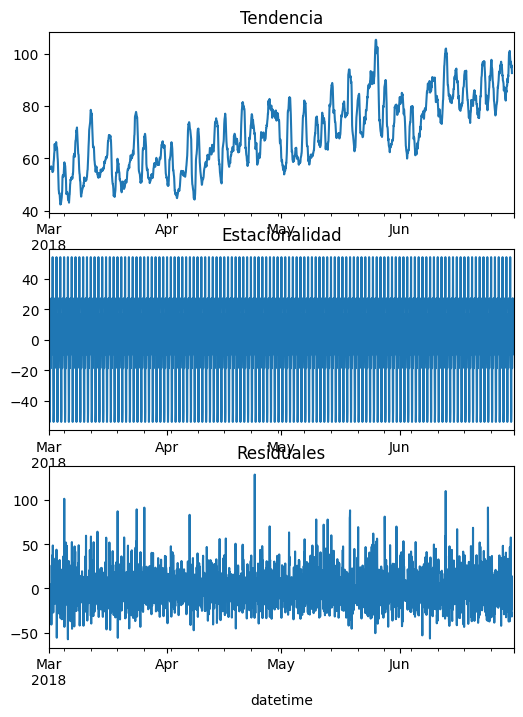

In [11]:
#Analizar tendencias y estacionalidad
df_res_3 = df_res['2018-03':'2018-06']

decomposed = seasonal_decompose(df_res_3)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')



Se puede observar que existe una clara tendencia de crecimiento. Por otra parte, la gráfica de estacionalidad muestra un patron repetitivo que puede indicar incrementos o disminuciones en las órdenesen ciertos periodos. 

In [12]:
#Crear características
def make_features(df, lag=(1,2,5,24), roll_window=(5,24,120)):
    df['month'] = df.index.month
    df['dow'] = df.index.dayofweek
    df['weekend'] = (df['dow'] >=5).astype('int')
    df['hour'] = df.index.hour

    for l in lag:
        df[f"num_orders_lag{l}"] = df['num_orders'].shift(l)

    for w in roll_window:
        df[f"num_orders_mean{w}"] = df['num_orders'].shift().rolling(w).mean()
        df[f"num_orders_std{w}"] = df['num_orders'].shift().rolling(w).std()
        
    return df

df_features = make_features(df_res)
print(df_features.shape)
print('')
print(df_features.info())

(4416, 15)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_orders          4416 non-null   int64  
 1   month               4416 non-null   int64  
 2   dow                 4416 non-null   int64  
 3   weekend             4416 non-null   int64  
 4   hour                4416 non-null   int64  
 5   num_orders_lag1     4415 non-null   float64
 6   num_orders_lag2     4414 non-null   float64
 7   num_orders_lag5     4411 non-null   float64
 8   num_orders_lag24    4392 non-null   float64
 9   num_orders_mean5    4411 non-null   float64
 10  num_orders_std5     4411 non-null   float64
 11  num_orders_mean24   4392 non-null   float64
 12  num_orders_std24    4392 non-null   float64
 13  num_orders_mean120  4296 non-null   float64
 14  num_orders_std120   4296 non-null   float64
dtyp

Los lags y rollings generan valores nulos esperados, sin embargo, para generar un modelo es necesario que todos los datos estén completos. Por este motivo, se eliminarán los valores nulos ya que solo implican 120 filas en este caso correspondiendo a un 2.7% que es aceptable.

In [13]:
#Eliminar valores nulos
df_features = df_features.dropna()

print('Valores nulos')
print(df_features.isna().sum())

Valores nulos
num_orders            0
month                 0
dow                   0
weekend               0
hour                  0
num_orders_lag1       0
num_orders_lag2       0
num_orders_lag5       0
num_orders_lag24      0
num_orders_mean5      0
num_orders_std5       0
num_orders_mean24     0
num_orders_std24      0
num_orders_mean120    0
num_orders_std120     0
dtype: int64


## Formación y Prueba

In [14]:
#Dividir en conjuntos train y test

X = df_features.drop('num_orders', axis=1)
y = df_features['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

In [15]:
#Generar un baseline con y_pred = lag1
y_pred_baseline = X_test['num_orders_lag1']
y_test_baseline = y_test.loc[y_pred_baseline.index]
rmse_baseline = mean_squared_error(y_test_baseline, y_pred_baseline, squared=False)
print('rmse baseline:', rmse_baseline)

rmse baseline: 59.12776863078645


In [16]:
#Regresión lineal con escalado de datos
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

model = LinearRegression()

model.fit(X_train_scaler, y_train)
y_pred = model.predict(X_test_scaler)

#Evaluación del modelo con RMSE
rmse_lr = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE Linear Regression:', rmse_lr)

RMSE Linear Regression: 47.3325298864363


In [20]:
#RandomForest
model_rf = RandomForestRegressor(random_state=12345)

param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

tscv = TimeSeriesSplit(n_splits=3)

grid_rf = GridSearchCV(model_rf,
                      param_grid_rf,
                      cv=tscv, 
                      scoring='neg_root_mean_squared_error',
                      n_jobs=-1, 
                      verbose=1)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test)

#Evaluación del modelo con RMSE
rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print('Mejores hiperparámetros:', grid_rf.best_params_)
print('RMSE Random Forest:', rmse_rf)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
RMSE Random Forest: 43.880378625840656


In [33]:
#XGBoost
model_xgb = XGBRegressor(random_state=12345)

param_grid_xgb = {
    'n_estimators': [20, 70],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1]
}

grid_xgb = GridSearchCV(model_xgb,
                       param_grid_xgb,
                       cv=tscv,
                       scoring='neg_root_mean_squared_error',
                       n_jobs=-1, 
                       verbose=1)

grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)


#Evaluación del modelo con RMSE
rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)
print('Mejores hiperparámetros:', grid_xgb.best_params_)
print('RMSE XGBoost:', rmse_xgb)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 70}
RMSE XGBoost: 46.328012557702934


In [29]:
#LightGBM
model_lgbm = LGBMRegressor(random_state=12345)

param_grid_lgbm = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, None],
    'learning_rate': [0.05, 0.1]
}

grid_lgbm = GridSearchCV(model_lgbm,
                        param_grid_lgbm,
                        cv=tscv,
                        scoring = 'neg_root_mean_squared_error',
                        n_jobs=-1, 
                        verbose=1)

grid_lgbm.fit(X_train, y_train)
best_lgbm = grid_lgbm.best_estimator_
y_pred = best_lgbm.predict(X_test)

#Evaluación del modelo con RMSE
rmse_lgbm = mean_squared_error(y_test, y_pred, squared=False)
print('Mejores hiperparámetros:', grid_lgbm.best_params_)
print('RMSE LightGBM:', rmse_lgbm)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
RMSE LightGBM: 40.96770369893194


In [34]:
#Comparación de resultados
df_all = pd.DataFrame({'Modelo': ['Baseline','Regresion lineal', 'Random Forest', 'XGBoost', 'LightGBM'],
                       'RMSE':[rmse_baseline, rmse_lr, rmse_rf, rmse_xgb, rmse_lgbm]})
print(df_all)

             Modelo       RMSE
0          Baseline  59.127769
1  Regresion lineal  47.332530
2     Random Forest  43.880379
3           XGBoost  46.328013
4          LightGBM  40.967704


## Conclusiones

- Todos los modelos evaluados tienen un RMSE menor a 48, menos el baseline que fue una aproximación rápida a partir del dato de número de órdenes previas.
- El modelo más adecuado según la métrica de RMSE es LightGBM que tiene el menor error (40.96)
- Es posible que el resultado del modelo XGBoost tenga una métrica de evaluación mayor al RandomForest porque deben ajustarse mejor los hiperparámetros, pero por una cuestión de memoria y tiempo se optimizaron con menos opciones